__<span style="background-color:#ffffe0">第5章　時系列データを活用したビジネス事例</span>__

# 5.4　離反予測モデルによる離反対策ルールの策定（食品・法人向けビジネス）

## ステップ1：準備

### 必要なモジュールの読み込み

In [1]:
#
# 必要なモジュールの読み込み
#

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフスタイル
plt.rcParams['figure.figsize'] = [12, 9] #グラフサイズ
plt.rcParams['font.size'] = 14 #フォントサイズ

### データセットの読み込み

In [2]:
#
# 必要なデータセットの読み込み
#

dataset = 'chap5_6.csv'
df=pd.read_csv(dataset) 

print(df) #確認

            cd  churn  Order_Quantity  Diff_Order_Quantity  Sales_Visit  \
0    599178001      0           69818                   94           42   
1    754552002      0          242000                   51           14   
2    308245003      0            9000                  -80           26   
3    384496004      0          268500                  -53           19   
4    575567005      0           52909                   95           51   
..         ...    ...             ...                  ...          ...   
579  819491580      1           12000                 -160            0   
580  700143581      1           18000                 -164            4   
581  387051582      1           60000                 -481           10   
582  273133583      1           54000                 -956            1   
583  695984584      1           12000                 -582            1   

     Diff_Sales_Visit  
0                  -5  
1                   4  
2                  -2  
3  

## ステップ2：決定木（デシジョンツリー）による訪問ルール抽出

### 決定木モデルの構築

In [3]:
#
# 目的変数yと説明変数X
#

y = df['churn']                     #目的変数y
X = df.drop(['cd','churn'], axis=1) #説明変数X

In [4]:
#
# 学習
#

# インスタンス生成
clf = DecisionTreeClassifier(
    max_depth=3, random_state=123)

# 学習
clf.fit(X, y)

# 正解率（accuracy）
print('accuracy:\n', clf.score(X, y)) 

accuracy:
 0.9982876712328768


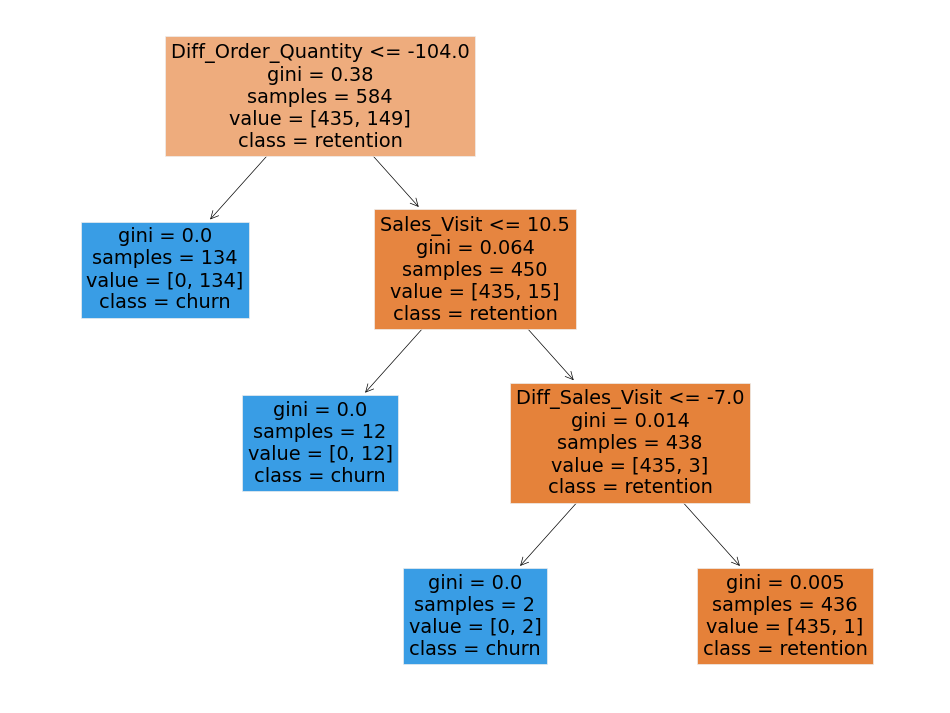

In [5]:
#
# 決定木の図示化
#

plot_tree(
    clf,
    filled=True, 
    feature_names=X.columns,
    class_names=['retention', 'churn'])

plt.show()

In [6]:
#
# 特徴量重要度（Feature Importances）
#

df_importance = pd.DataFrame(
    zip(X.columns, clf.feature_importances_),
    columns=["Features","Importance"])

df_importance = df_importance.sort_values(
    "Importance",ascending=False)

print(df_importance) #確認

              Features  Importance
1  Diff_Order_Quantity    0.877237
2          Sales_Visit    0.104745
3     Diff_Sales_Visit    0.018018
0       Order_Quantity    0.000000


## ステップ3：予測モデルの作り方の検討

### 学習データ（70%）とテストデータ（30%）に分割

In [7]:
#
# データセットを学習データとテストデータ（30%）に分割
#

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=123)

### 学習

In [8]:
#
# ハイパーパラメータ探索
#

# ハイパーパラメータ探索の設定
params = {
    'max_depth':list(range(1, 10)),
    'criterion': ['gini', 'entropy','log_loss'],
    'min_samples_leaf':list(range(1, 10)),
    'min_samples_split':list(range(1, 5))
}
 
# グリッドサーチのインスタンス生成
GS = GridSearchCV(
    DecisionTreeClassifier(),
    params,
    cv=10)

# 探索実施
GS.fit(X_train, y_train)
 
# 探索結果
print(GS.best_params_)

{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


### テストデータで精度検証

In [9]:
#
# テストデータで精度評価
#

# 最適ハイパーパラメータのモデル
GS_best = GS.best_estimator_

# 予測
test_pred = GS_best.predict(X_test)

# 混同行列(confusion matrix)
cm_matrix = confusion_matrix(y_test, test_pred)

# 混同行列をデータフレーム化して表示
lab = ['retention', 'churn']
act = ['Actual','Actual']
pred = ['Predicted','Predicted']

cm_df = pd.DataFrame(
    cm_matrix, 
    columns=[pred, lab], 
    index=[act, lab])

print(cm_df)
print('\n--------------------------------------------------------\n')

# 各評価指標
print(
    classification_report(
        y_test,
        test_pred,
        target_names=['retention', 'churn']))

                 Predicted      
                 retention churn
Actual retention       127     0
       churn             1    48

--------------------------------------------------------

              precision    recall  f1-score   support

   retention       0.99      1.00      1.00       127
       churn       1.00      0.98      0.99        49

    accuracy                           0.99       176
   macro avg       1.00      0.99      0.99       176
weighted avg       0.99      0.99      0.99       176



### 全データでモデル構築

In [10]:
#
# モデル構築
#

# 最適なハイパーパラメータを探索
GS.fit(X, y)

# 最適ハイパーパラメータのモデル
clf_best = GS.best_estimator_

# 正解率（accuracy）
print('accuracy:\n', clf_best.score(X, y)) 

accuracy:
 0.9982876712328768
